In [1]:
#                     imports       
# ===========================================================================

import torch
import numpy as np
import torch.nn as nn 

In [2]:
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from IPython.display import clear_output

# transforms for data
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5), (0.5))])

train_set = MNIST(root='./MNIST', train=True, download=True, transform=transform)
test_set = MNIST(root='./MNIST', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()

In [3]:
#                    CNN
# ===========================================================================

class CNN_model_big(nn.Module):

    def __init__(self):
        super(CNN_model_big, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # входной канал=1 (изображение ч.б), на выходе 32 фильтра, размер ядра свертки 3x3, паддинг 1
            nn.MaxPool2d(2), # size [32,14,14]
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), # in channel=32, out=32
            nn.MaxPool2d(2), # size [32,7,7]
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32*7*7, 100), # размерность на входе линейного слоя = количество_каналов*высота*ширина
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x): 
        x = self.conv_stack(x) 
        return x

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change run time to gpu to fast training
torch.manual_seed(0)
np.random.seed(0)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
model = CNN_model_big().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
num_epochs = 10
loss_hist = [] # for plotting
for epoch in range(num_epochs):
    hist_loss = 0
    for _, batch in enumerate(train_loader, 0): # get batch
        # обрабатываем batch 
        imgs, labels = batch
        imgs, labels = imgs.to(device), labels.to(device)
        # Зануляем градиенты
        optimizer.zero_grad() 
        # получаем выходы сети
        y_pred = model(imgs) 
        # вычисляем loss
        loss = criterion(y_pred, labels)
        # вычисляем градиенты
        loss.backward() 
        # выполняем один шаг оптимизатора (обновляем параметры сети)
        optimizer.step()
        hist_loss += loss.item()
    loss_hist.append(hist_loss / len(train_loader))
    print(f"Epoch={epoch} loss={loss_hist[epoch]:.4f}")


Epoch=0 loss=0.1829
Epoch=1 loss=0.0542
Epoch=2 loss=0.0370
Epoch=3 loss=0.0297
Epoch=4 loss=0.0231
Epoch=5 loss=0.0183
Epoch=6 loss=0.0155
Epoch=7 loss=0.0122
Epoch=8 loss=0.0106
Epoch=9 loss=0.0086


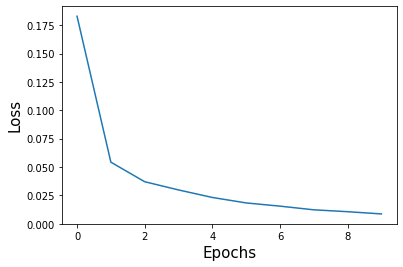

In [6]:
import matplotlib.pyplot as plt

plt.plot(range(num_epochs), loss_hist)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()

In [7]:
def calaculate_accuracy(model, data_loader):
    correct, total = 0, 0 
    with torch.no_grad(): 
        for batch in data_loader: # get batch
            imgs, labels = batch # parse batch
            imgs, labels = imgs.to(device), labels.to(device)
            y_pred = model.forward(imgs) # get output
            _, predicted = torch.max(y_pred.data, 1) # get predicted class
            total += labels.size(0) # all examples
            correct += (predicted == labels).sum().item() # correct predictions 
    return correct / total 

acc_train = round(calaculate_accuracy(model, train_loader), 3)
print(f"Accuracy train = {acc_train}")
acc_test = round(calaculate_accuracy(model, test_loader), 3)
print(f"Accuracy test = {acc_test}")

Accuracy train = 0.998
Accuracy test = 0.992


In [8]:
from google.colab import files
uploaded = files.upload() #Загрузим файл с изображением

Saving test_digit.png to test_digit.png


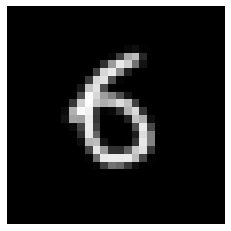

tensor([[ -3.4143, -10.3395,  -3.9735,  -0.9025,  -3.3412,  -2.0626,   2.6440,
         -10.7340,   1.8841,   1.5986]], grad_fn=<AddmmBackward0>)
Предсказанный класс:  [6]


In [9]:
from PIL import Image
from torchvision import transforms

img_upl = Image.open(list(uploaded.keys())[0]) #откроем изображение
transform = transforms.Compose([transforms.Resize((28, 28)), #конвертируем в размер 28 на 28 пикселей
                                transforms.ToTensor()])

tensor = transforms.functional.rgb_to_grayscale(transform(img_upl)) #переводим в ч.б. изображение
tensor = transforms.functional.invert(tensor)
tensor.to(device)
pred = model(tensor.unsqueeze(0)) #получим выход с сети на нашей картинке

plt.rcParams["figure.figsize"] = (4, 4)
plt.imshow(tensor.squeeze(),cmap='gray')
plt.axis('off')
plt.show()

digits = np.argmax(pred.detach().numpy(), axis=1)
print(pred)
print('Предсказанный класс: ', digits)